In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/ixn.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/fcor.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/urty.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/ipff.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/pxf.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/qld.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/cmbs.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/fdd.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/vixm.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/pbj.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/vbr.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/hys.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/xlv.us.txt
/kaggle/input/price-volume-data-for-all-us-stocks-etfs/ETFs/ttfs.us.txt


In [2]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# # Time series decomposition
# from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(255,255,2555,0.5)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

# Data Loading

In [3]:
ETF_NAME = 'CERN'
ETF_DIRECTORY = '/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Data/Stocks/'
YEAR = 2010


df = pd.read_csv(os.path.join(ETF_DIRECTORY, ETF_NAME.lower() + '.us.txt'), sep=',')
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= YEAR)].copy()
df.index = range(len(df))

df.head()

Date    Open    High     Low   Close   Volume  OpenInt
0 2010-01-04  20.940  21.103  20.713  21.068  3058908        0
1 2010-01-05  21.355  22.345  21.250  22.313  7324724        0
2 2010-01-06  22.500  22.873  22.265  22.548  6844460        0
3 2010-01-07  22.423  22.750  22.230  22.680  2968936        0
4 2010-01-08  22.578  22.663  22.345  22.633  3238372        0

In [4]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

## Technical indicators

In [5]:
# Relative Strength Index
def compute_momentum(ser):
  '''
  Momentum_1D = P(t) - P(t-1)
  '''
  ser['Momentum_1D'] = (ser['Close'] - ser['Close'].shift(1)).fillna(0)
  return ser


def rsi(values):
  '''
  Relative Strength Index
  '''
  up = values[values>0].mean()
  down = -1*values[values<0].mean()
  return 100 * up / (up + down)


def compute_rsi(ser, window=14):
  df = compute_momentum(ser)
  return df['Momentum_1D'].rolling(center=False, window=window).apply(rsi).fillna(0)


# df['RSI_7'] = compute_rsi(df, 7).fillna(0)
# df['RSI_14'] = compute_rsi(df, 14).fillna(0)

# fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI_14, name='RSI'))
# fig.show()



# MACD
def MACD(ser):
    ser['EMA_26'] = ser['Close'].ewm(span=26,min_periods=0,adjust=True,ignore_na=False).mean()
    ser['EMA_12'] = ser['Close'].ewm(span=12,min_periods=0,adjust=True,ignore_na=False).mean()
    ser['MACD'] = ser['EMA_12'] - ser['EMA_26']
    ser['MACD_signal'] = pd.Series(ser.MACD.ewm(span=9, min_periods=9).mean())
    ser = ser.fillna(0)
     


# Bollinger Bands
def bbands(price, length=30, numsd=2):
    """ returns average, upper band, and lower band"""
    #ave = pd.stats.moments.rolling_mean(price,length)
    ave = price.rolling(window = length, center = False).mean()
    #sd = pd.stats.moments.rolling_std(price,length)
    sd = price.rolling(window = length, center = False).std()
    upband = ave + (sd*numsd)
    dnband = ave - (sd*numsd)
    return np.round(ave,3), np.round(upband,3), np.round(dnband,3)


def compute_BB(ser):
  '''

  '''
  ser['BB_Middle_Band'], ser['BB_Upper_Band'], ser['BB_Lower_Band'] = bbands(ser['Close'], length=20, numsd=1)
  ser['BB_Middle_Band'] = ser['BB_Middle_Band'].fillna(0)
  ser['BB_Upper_Band'] = ser['BB_Upper_Band'].fillna(0)
  ser['BB_Lower_Band'] = ser['BB_Lower_Band'].fillna(0)
  #return ser 



# Triple Exponential MA 
def compute_ema_and_tema(ser):
  ser['EMA_3D'] = ser['Close'].ewm(span=3, min_periods=0, adjust=True, ignore_na=False).mean()
  ser['EMA_9D'] = ser['Close'].ewm(span=9, min_periods=0, adjust=True, ignore_na=False).mean()
  ser['diff_EMA'] = ser['EMA_3D'] - ser['EMA_9D']
  ser['SMA_5'] = ser['Close'].rolling(5).mean().shift()
  ser['TEMA'] = (3 * ser['EMA_3D'] - 3 * ser['EMA_3D'] * ser['EMA_3D']) + (ser['EMA_3D']*ser['EMA_3D']*ser['EMA_3D'])
  return ser 


# Stochastic
def compute_stochastic(df, n):
    df['ST_K'] = ((df['Close'] - df['Low'].rolling(window=n, center=False).mean()) / (df['High'].rolling(window=n, center=False).max() - df['Low'].rolling(window=n, center=False).min())) * 100
    df['ST_D'] = df['ST_K'].rolling(window = 3, center=False).mean()
    df = df.fillna(0)


# set moving average
def set_MA(df):
    df['EMA_3'] = df['Close'].ewm(3).mean().shift()
    df['EMA_8'] = df['Close'].ewm(8).mean().shift()

    df['SMA_5'] = df['Close'].rolling(5).mean().shift()
    df['SMA_13'] = df['Close'].rolling(13).mean().shift()


    


def set_indicator(df):
    df['RSI_7D'] = compute_rsi(df, 7)
    df['RSI_14D'] = compute_rsi(df, 14)
    MACD(df)
    
    compute_stochastic(df, 4)
    compute_BB(df)
    set_MA(df)
    return df
    

set_MA(df)
df = set_indicator(df)
df.tail()

#compute_BB(df)

Date   Open    High    Low  Close   Volume  OpenInt      EMA_3  \
1974 2017-11-06  65.36  65.810  65.06  65.71  1359851        0  66.923125   
1975 2017-11-07  65.78  66.240  65.67  65.93  1404928        0  66.619844   
1976 2017-11-08  65.85  66.470  65.60  66.28  1331746        0  66.447383   
1977 2017-11-09  65.87  66.105  64.69  65.48  1491859        0  66.405537   
1978 2017-11-10  65.31  65.560  64.93  65.31  1327855        0  66.174153   

          EMA_8   SMA_5  ...    RSI_14D     EMA_26     EMA_12      MACD  \
1974  68.861038  66.074  ...  28.937818  69.112341  67.773819 -1.338523   
1975  68.510923  65.924  ...  29.211858  68.876612  67.490154 -1.386458   
1976  68.224153  65.606  ...  30.812721  68.684271  67.303977 -1.380294   
1977  68.008136  65.764  ...  34.215430  68.446917  67.023365 -1.423552   
1978  67.727232  65.766  ...  35.064935  68.214553  66.759770 -1.454783   

      MACD_signal       ST_K       ST_D  BB_Middle_Band  BB_Upper_Band  \
1974    -0.553915  23.412698   7.262061          70.034         73.216   
1975    -0.720424  50.838926  23.864017          69.760         73.050   
1976    -0.852398  63.475177  45.908934          69.498         72.849   
1977    -0.966629  12.640449  42.318184          69.185         72.607   
1978    -1.064260   4.915730  27.010452          68.772         72.135   

      BB_Lower_Band  
1974         66.852  
1975         66.469  
1976         66.147  
1977         65.762  
1978         65.408  

[5 rows x 23 columns]

In [6]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_3, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_8, name='EMA 8'))

fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_13, name='SMA 13'))

fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

In [7]:
fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

In [8]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=df.index, y=df.Close, name='Close',  marker_color='rgb(0, 0, 150)'))
fig.add_trace(go.Scatter(x=df.index, y=df.BB_Middle_Band, name='BB_mid' , marker_color='rgb(0, 150, 0)'))

fig.add_trace(go.Scatter(x=df.index, y=df['BB_Lower_Band'], mode='lines', name='BB_lower', marker_color='rgb(205, 188, 199)')) 
fig.add_trace(go.Scatter(x=df.index, y=df['BB_Upper_Band'], fill='tonexty', name='BB_upper', marker_color='rgb(205, 188, 199)') )

fig.show()

# Recurrent Neural Network approach

## Data Preparation: Time series conversion, normalization

In [9]:
# Params 
WINDOW = 13 # sequence length

batch_size = 512          # Batch size (you may try different values)
epochs = 200               # Epoch (you may try different values)
#seq_len = seq_len             # sequence data (Representing the last 30 days)
loss='mean_squared_error' # Since the metric is MSE/RMSE
optimizer = 'rmsprop'     # Recommended optimizer for RNN
activation = 'relu'       # Linear activation
input_shape=(None,1)      # Input dimension
output_dim = 40           # Output dimension


# optimizer = keras.optimizers.RMSprop(
#     learning_rate=0.01,
#     rho=0.9,
#     momentum=0.0,
#     epsilon=1e-07,
#     centered=False,
#     name="RMSprop"
# )

optimizer='rmsprop'

In [10]:
def train_test_split(df, train_length=0.90):
    '''
    /!\ Dont forget WINDOW PARAMS
    '''
    row = int(np.floor(df.shape[0]*train_length))
    train = df[:row]
    valid = df[row:]
    
    test = valid[-(WINDOW*2):] # to change
    valid = valid[:-(WINDOW*2)] # to change
    print("Train : ", train.shape)
    print("Test : ", test.shape)
    print("Validation : ", valid.shape)
    return train, test, valid, row


def create_timeseries(data, seq_len=30, stride=1):
  '''
  dataframe to timeseries. TimeseriesGenerator could be use instead
  '''
  price_matrix = []
  for index in range(0, len(data)-seq_len+1, stride):
      price_matrix.append(data.Close[index:(index+seq_len)]) # stride = 1
  price_matrix = np.array(price_matrix)
  return price_matrix
  

def normalize_windows(window_data):
    '''
    It normalizes each value to reflect the percentage changes from starting point
    '''
    normalised_data = []
    for window in window_data:
        normalised_window = [((float(p) / float(window[0])) - 1) for p in window]
        normalised_data.append(normalised_window)
    return np.array(normalised_data)

## Train test splitting

In [11]:
train, test, valid, row = train_test_split(df, 0.80)

fig = go.Figure()
fig.add_trace(go.Scatter(x=train.Date, y=train.Close, name='Training'))
fig.add_trace(go.Scatter(x=test.Date, y=test.Close, name='Test'))
fig.add_trace(go.Scatter(x=valid.Date, y=valid.Close, name='Validation'))
fig.show()

Train :  (1583, 23)
Test :  (26, 23)
Validation :  (370, 23)


### Define Series

In [12]:
train_ts = create_timeseries(train, WINDOW)
valid_ts = create_timeseries(valid, WINDOW)

X_train = normalize_windows(train_ts)
X_valid = normalize_windows(valid_ts)

# We want to predict the j+1 price
X_train, y_train = X_train[:row,:-1], X_train[:row,-1]
X_valid, y_valid = X_valid[:row,:-1], X_valid[:row,-1]

# reshaping [batch_size, n_steps, variability]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))

## Models
We're going to try two models, a simple RNN and a RNN with a convolution 1D 

In [13]:
from tensorflow import keras 
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, GRU, Dropout, BatchNormalization
import time

model = Sequential()
model.add(LSTM(units=output_dim, return_sequences=True, input_shape=input_shape, dropout=0.2))
model.add(Dense(units=64,activation=activation))
model.add(LSTM(units=output_dim, return_sequences=False, dropout=0.2))
model.add(Dense(units=1,activation=activation))
model.compile(optimizer=optimizer,loss=loss)


model1 = Sequential()
model1.add(keras.layers.Conv1D(filters=20, kernel_size=7, strides=2, padding="valid", input_shape=[None, 1]) )
model1.add(GRU(units=output_dim, return_sequences=True, input_shape=input_shape, dropout=0.2))
model1.add(Dense(units=64,activation=activation))
model1.add(GRU(units=output_dim, return_sequences=False, dropout=0.2))
model1.add(Dense(units=1,activation=activation))
model1.compile(optimizer=optimizer,loss=loss)

Epoch 1/200
4/4 [==============================] - 1s 206ms/step - loss: 0.0025 - val_loss: 0.0032
Epoch 2/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0023 - val_loss: 0.0018
Epoch 3/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 4/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 7/200
4/4 [==============================] - 0s 9ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 8/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 9/200
4/4 [==============================] - 0s 11ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 10/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 11/200
4/4 [=

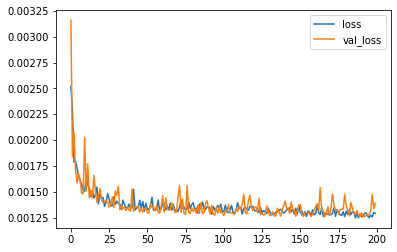

In [14]:
# Simple model fitting
history = model.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid),
                    batch_size=batch_size,
                    epochs=epochs)


pd.DataFrame(history.history).plot()

Epoch 1/200
4/4 [==============================] - 1s 184ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 2/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 3/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0021 - val_loss: 0.0017
Epoch 4/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 6/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 7/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0016
Epoch 9/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0017 - val_loss: 0.0016
Epoch 10/200
4/4 [==============================] - 0s 10ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 11/200
4/4 [

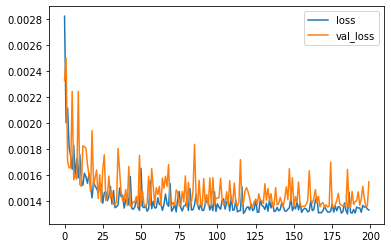

In [15]:
history1 = model1.fit(X_train, y_train, 
                    validation_data=(X_valid, y_valid),
                    batch_size=batch_size,
                    epochs=epochs)

pd.DataFrame(history1.history).plot()

In [16]:
model.evaluate(X_valid, y_valid)
model1.evaluate(X_valid, y_valid)

12/12 [==============================] - 0s 3ms/step - loss: 0.0015


0.0015497951535508037

### Thats looks good !

## Deserialization processing

In [17]:
# Deserialize
# dates = test.timestamp
def deserializer_pred(preds, df):
  preds = np.reshape(preds, (preds.shape[0]))
  preds_original = []
  # print(preds)
  for index in range(0, len(preds)):
      pred = (preds[index]+1)* df[index][0]
      preds_original.append(pred)
  preds_original = np.array(preds_original)
  return preds_original



def get_prediction_dataframe(df):
    ts = create_timeseries(df, WINDOW)
    df_normalized = normalize_windows(ts)
    print(df_normalized.shape)
    print(row)
    #X, y = df_normalized[:row,:-1], df_normalized[:row,-1]
    X, y = df_normalized[:,:-1], df_normalized[:,-1]
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    print("X shape: ", X.shape)

    preds = model.predict(X)
    preds1 = model1.predict(X)

    model.evaluate(X, y)
    model1.evaluate(X, y)

    preds_original = deserializer_pred(preds, ts)
    preds1_original = deserializer_pred(preds1, ts)


    res = pd.DataFrame({
        'timestamp' : df.Date[-preds_original.shape[0]:],
        'pred_nn' : preds_original, 
        'pred_conv' : preds1_original,
        'price': df.Close[-preds_original.shape[0]:]
    })
    
#     print(preds_original, ts[:row, -1])
#     print(preds1_original, ts[:row, -1])
    
    return res

### Test Result

In [18]:
res_test = get_prediction_dataframe(valid)
res_test.head()

(358, 13)
1583
X shape:  (358, 12, 1)
12/12 [==============================] - 0s 3ms/step - loss: 0.0015


timestamp  pred_nn  pred_conv  price
1595 2016-05-06    58.36      58.36  53.64
1596 2016-05-09    58.46      58.46  55.43
1597 2016-05-10    58.51      58.51  55.24
1598 2016-05-11    58.57      58.57  54.34
1599 2016-05-12    58.16      58.16  54.46

## Validation visualization

let's see in visualization

In [19]:
res_valid = get_prediction_dataframe(valid)

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=res_valid.timestamp, y=res_valid.pred_conv, name='Pred conv'), col=1, row=1)
fig.add_trace(go.Scatter(x=res_valid.timestamp, y=res_valid.pred_nn, name='Pred_nn'), col=1, row=1)
fig.add_trace(go.Scatter(x=res_valid.timestamp, y=res_valid.price, name='Real Prices'), col=1, row=1)
fig.show()


(358, 13)
1583
X shape:  (358, 12, 1)
12/12 [==============================] - 0s 3ms/step - loss: 0.0015


## the models fail to predict in November 2017 on validation

In [20]:
res_train = get_prediction_dataframe(train)

res=res_train
fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=res.timestamp, y=res.pred_conv, name='Pred conv'), col=1, row=1)
fig.add_trace(go.Scatter(x=res.timestamp, y=res.pred_nn, name='Pred_nn'), col=1, row=1)
fig.add_trace(go.Scatter(x=res.timestamp, y=res.price, name='Real Prices'), col=1, row=1)
fig.show()


(1571, 13)
1583
X shape:  (1571, 12, 1)
50/50 [==============================] - 0s 3ms/step - loss: 0.0015


# XGB approach with nn prediction as feature

## 1. Simple XGB

## Data preparation

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

features = [ 'Open', 'High', 'Low', 'Close', 'Volume',
       'EMA_3', 'EMA_8', 'SMA_5', 'SMA_13', 'Momentum_1D', 'RSI_7D', 'RSI_14D',
       'EMA_26', 'EMA_12', 'MACD', 'MACD_signal', 'BB_Middle_Band',
       'BB_Upper_Band', 'BB_Lower_Band'] #, 'pred_nn', 'pred_conv']

# Date could be one hot encoded if needed. I don't think so , so far


# Train 
train_xgb = train.copy().set_index('Date')
train_xgb['price_tomorrow'] = train_xgb['Close'].shift(-1)
train_xgb = train_xgb.dropna()
#x_train, y_train = scaler.fit_transform(train_xgb[features]), train_xgb['price_tomorrow']
x_train, y_train = train_xgb[features], train_xgb['price_tomorrow']


# Validation 
valid_xgb = valid.copy().set_index('Date')
valid_xgb['price_tomorrow'] = valid_xgb['Close'].shift(-1)
valid_xgb = valid_xgb.dropna()
#x_valid, y_valid = scaler.transform(valid_xgb[features]), valid_xgb['price_tomorrow']
x_valid, y_valid = valid_xgb[features], valid_xgb['price_tomorrow']



# Test
test_xgb = test.copy().set_index('Date')
test_xgb['price_tomorrow'] = test_xgb['Close'].shift(-1)
test_xgb = test_xgb.dropna()
#x_test, y_test = scaler.transform(test_xgb[features]), test_xgb['price_tomorrow']
x_test, y_test = test_xgb[features], test_xgb['price_tomorrow']



print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


# train_xgb.isnull().sum().sort_values(ascending = False)

(1569, 19) (1569,)
(369, 19) (369,)
(25, 19) (25,)


In [22]:
%%time
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.02, 0.05, 0.1],
    'max_depth': [5, 10, 12],
    'gamma': [0.001, 0.1, 0.2],
    'random_state': [42]
}

eval_set = [(x_train, y_train), (x_valid, y_valid)]
xgb = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=True)
clf = GridSearchCV(xgb, parameters, n_jobs=-1, verbose=5, scoring='r2')

# clf.fit(x_train, y_train)
# print('Best params: ', clf.best_params_)
# print('Best validation score = ', clf.best_score_)

CPU times: user 151 µs, sys: 0 ns, total: 151 µs
Wall time: 155 µs


In [23]:
%%time
from xgboost import XGBRegressor

#model_xgb = XGBRegressor(**clf.best_params_, objective='reg:squarederror')

model_xgb = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=5,
             min_child_weight=1,monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

model_xgb.fit(x_train, y_train, eval_set=eval_set, verbose=False)

model_xgb

CPU times: user 1.24 s, sys: 10.6 ms, total: 1.25 s
Wall time: 1.08 s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

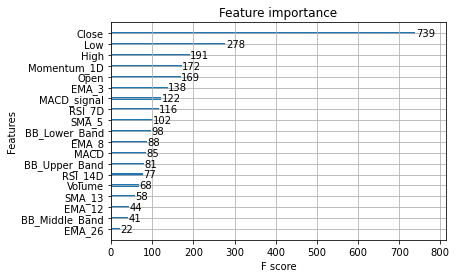

In [24]:
from xgboost import plot_importance, plot_tree
plot_importance(model_xgb)

In [25]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model_xgb.predict(x_valid)

print(f'y_true = {np.array(y_valid)[:5]}')
print(f'y_pred = {y_valid[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_valid, y_pred)}')
print(f'r2_score = {r2_score(y_valid, y_pred)}')

y_true = [58.46 58.51 58.57 58.16 57.81]
y_pred = Date
2016-04-20    58.46
2016-04-21    58.51
2016-04-22    58.57
2016-04-25    58.16
2016-04-26    57.81
Name: price_tomorrow, dtype: float64
mean_squared_error = 2.149688888151682
r2_score = 0.9459131609191274


In [26]:
predicted_prices = valid_xgb.copy()
predicted_prices['truth'] = valid_xgb['Close']
predicted_prices['pred_xgb'] = model_xgb.predict(x_valid)

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=predicted_prices.index, y=predicted_prices.truth,
                         name='Truth',
                         marker_color='green'), row=1, col=1)


fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.pred_xgb,
                         name='xgb',
                         marker_color='MediumPurple'), row=1, col=1)

fig.show()


## Beware : From what I understand xgboost is not very good at extrapolating unseen values and is a problem with all tree based...


You can see that by taking apple stock ( 'aapl') 

One of problem causing "the prediction way lower than the price" is that tree-based algorithms (like XGBRegressor used here) cannot extrapolate data. If you take a look at the plot with data split, imagine that all what an algorithm sees when training is train set obviously. For the algorithm, train set bounds are total bounds for the rest of data.

So if your validation or test set reach higher than training set maximum value, tree-based classes cannot predict them correctly. They will predict the value as the maximum they are aware of.

Here I fixed this just by picking another stock (when highest high value is within train set).

In [27]:
predicted_prices.tail(10)[['pred_xgb', 'truth']]

pred_xgb  truth
Date                        
2017-09-21  68.599937  69.48
2017-09-22  68.617500  69.63
2017-09-25  68.170303  69.39
2017-09-26  68.644722  69.86
2017-09-27  69.356438  71.07
2017-09-28  69.257988  70.78
2017-09-29  70.406425  71.32
2017-10-02  70.904015  72.33
2017-10-03  70.606209  72.05
2017-10-04  70.473450  71.79

In [28]:
predicted_prices = test_xgb.copy()
predicted_prices['truth'] = test_xgb['Close']
predicted_prices['pred_xgb'] = model_xgb.predict(x_test)

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=predicted_prices.index, y=predicted_prices.truth,
                         name='Truth',
                         marker_color='green'), row=1, col=1)


fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.pred_xgb,
                         name='xgb',
                         marker_color='MediumPurple'), row=1, col=1)

fig.show()

## 2. XGB by using NN outputs as features 

In [29]:
features_with_nn =  ['Open', 'High', 'Low', 'Close', 'Volume',
       'EMA_3', 'EMA_8', 'SMA_5', 'SMA_13', 'Momentum_1D', 'RSI_7D', 'RSI_14D',
       'EMA_26', 'EMA_12', 'MACD', 'MACD_signal', 'BB_Middle_Band',
       'BB_Upper_Band', 'BB_Lower_Band', 'pred_nn', 'pred_conv']

scaler1 = StandardScaler()

# # Train 
res_train = get_prediction_dataframe(train)
train_xgb = pd.merge(train, res_train, left_on='Date', right_on='timestamp', how='inner')

train_xgb['price_tomorrow'] = train_xgb['Close'].shift(-1)
train_xgb = train_xgb.dropna()
# x_train, y_train = scaler1.fit_transform(train_xgb[features_with_nn]), train_xgb['price_tomorrow']
x_train, y_train = train_xgb[features_with_nn], train_xgb['price_tomorrow']



# # Validation 
res_valid = get_prediction_dataframe(valid)
valid_xgb = pd.merge(valid, res_valid, left_on='Date', right_on='timestamp', how='inner')

valid_xgb['price_tomorrow'] = valid_xgb['Close'].shift(-1)
valid_xgb = valid_xgb.dropna()
#x_valid, y_valid = scaler1.transform(valid_xgb[features_with_nn]), valid_xgb['price_tomorrow']
x_valid, y_valid = valid_xgb[features_with_nn], valid_xgb['price_tomorrow']


# # Test 
res_test = get_prediction_dataframe(test)
test_xgb = pd.merge(test, res_test, left_on='Date', right_on='timestamp', how='inner')

test_xgb['price_tomorrow'] = test_xgb['Close'].shift(-1)
test_xgb = test_xgb.dropna()
# x_test, y_test = scaler1.transform(test_xgb[features_with_nn]), test_xgb['price_tomorrow']
x_test, y_test = test_xgb[features_with_nn], test_xgb['price_tomorrow']




print(x_train.shape, y_train.shape)
print(x_valid.shape, y_valid.shape)
print(x_test.shape, y_test.shape)


test.head()

(1571, 13)
1583
X shape:  (1571, 12, 1)
50/50 [==============================] - 0s 3ms/step - loss: 0.0015
(358, 13)
1583
X shape:  (358, 12, 1)
12/12 [==============================] - 0s 3ms/step - loss: 0.0015
(14, 13)
1583
X shape:  (14, 12, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.0071
(1569, 21) (1569,)
(357, 21) (357,)
(13, 21) (13,)


Date   Open    High     Low  Close   Volume  OpenInt      EMA_3  \
1953 2017-10-06  71.53  71.895  71.260  71.53  1009834        0  71.421852   
1954 2017-10-09  71.52  71.720  71.290  71.44  1134560        0  71.448889   
1955 2017-10-10  71.62  71.650  71.265  71.42  2137827        0  71.446667   
1956 2017-10-11  71.08  71.580  70.910  71.51  1523945        0  71.440000   
1957 2017-10-12  71.64  72.070  71.390  71.75  1954854        0  71.457500   

          EMA_8   SMA_5  ...    RSI_14D     EMA_26     EMA_12      MACD  \
1953  70.537277  71.810  ...  70.919325  69.883828  71.072524  1.188695   
1954  70.647579  71.852  ...  73.548387  69.999100  71.129058  1.129958   
1955  70.735626  71.674  ...  78.564050  70.104352  71.173819  1.069467   
1956  70.811668  71.548  ...  76.263736  70.208474  71.225539  1.017065   
1957  70.889260  71.492  ...  76.724138  70.322661  71.306225  0.983564   

      MACD_signal       ST_K       ST_D  BB_Middle_Band  BB_Upper_Band  \
1953     1.234830   2.287582   8.248350          70.743         71.742   
1954     1.213856   8.474576   4.583193          70.790         71.800   
1955     1.184978  19.359756  10.040638          70.812         71.831   
1956     1.151395  33.375635  20.403322          70.862         71.890   
1957     1.117829  46.228448  32.987946          70.853         71.870   

      BB_Lower_Band  
1953         69.743  
1954         69.780  
1955         69.793  
1956         69.834  
1957         69.835  

[5 rows x 23 columns]

In [30]:
%%time

eval_set = [(x_train, y_train), (x_valid, y_valid)]
xgb = XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=True)
clf = GridSearchCV(xgb, parameters, n_jobs=-1, verbose=5, scoring='r2')


# clf.fit(x_train, y_train)

# print('Best params: ', clf.best_params_)
# print('Best validation score = ', clf.best_score_)

CPU times: user 122 µs, sys: 12 µs, total: 134 µs
Wall time: 139 µs


In [31]:
%%time
from xgboost import XGBRegressor

#model_xgb1 = XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model_xgb1 = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=5,
             min_child_weight=1, monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

model_xgb1.fit(x_train, y_train, eval_set=eval_set, verbose=False)

model_xgb1

CPU times: user 821 ms, sys: 0 ns, total: 821 ms
Wall time: 823 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.001, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.02, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=-1, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

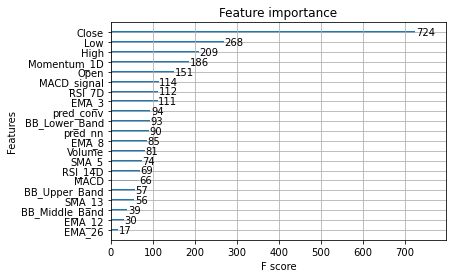

In [32]:
from xgboost import plot_importance, plot_tree
plot_importance(model_xgb1)

In [33]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model_xgb1.predict(x_valid)
print(f'y_true = {np.array(y_valid)[:5]}')
print(f'y_pred = {y_valid[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_valid, y_pred)}')
print(f'r2_score = {r2_score(y_valid, y_pred)}')

y_true = [55.43 55.24 54.34 54.46 53.74]
y_pred = 0    55.43
1    55.24
2    54.34
3    54.46
4    53.74
Name: price_tomorrow, dtype: float64
mean_squared_error = 2.170572597467857
r2_score = 0.9467572690664187


In [34]:
predicted_prices = x_valid.copy()
predicted_prices['truth'] = y_valid
predicted_prices['pred_xgb'] = model_xgb1.predict(x_valid)

# predicted_prices = predicted_prices.set_index('Date')

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=predicted_prices.index, y=predicted_prices.truth,
                         name='Truth',
                         marker_color='green'), row=1, col=1)


fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.pred_xgb,
                         name='xgb',
                         marker_color='MediumPurple'), row=1, col=1)


fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.pred_conv,
                         name='NN conv',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.pred_nn,
                         name='NN',
                         marker_color='blue', opacity=0.2), row=1, col=1)

fig.show()

### Observation

This approach helps xgb to be more accurate 

In [35]:
predicted_prices = x_train.copy()
predicted_prices['truth'] = y_train
predicted_prices['pred_xgb'] = model_xgb1.predict(x_train)

# predicted_prices = predicted_prices.set_index('Date')

fig = make_subplots(rows=1, cols=1)
fig.add_trace(go.Scatter(x=predicted_prices.index, y=predicted_prices.truth,
                         name='Truth',
                         marker_color='green'), row=1, col=1)


fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.pred_xgb,
                         name='xgb',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.pred_conv,
                         name='NN conv',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.index,
                         y=predicted_prices.pred_nn,
                         name='NN',
                         marker_color='blue', opacity=0.2), row=1, col=1)

fig.show()

In [36]:
test.shape

(26, 23)

In [37]:
predicted_prices.tail(10)[['pred_xgb', 'truth']]

pred_xgb  truth
1560  53.215309  55.23
1561  53.832275  55.98
1562  55.124878  56.45
1563  55.373795  55.11
1564  54.203274  55.50
1565  54.765289  55.91
1566  55.277630  56.44
1567  55.393311  57.02
1568  55.983273  58.08
1569  56.999722  58.04

In [38]:
predicted_prices = x_test.copy()
predicted_prices['truth'] = y_test
predicted_prices['pred_xgb'] = model_xgb1.predict(x_test)

predicted_prices[['pred_xgb', 'truth', 'pred_nn', 'pred_conv']]

pred_xgb  truth    pred_nn  pred_conv
0   70.951332  71.80  72.800337  74.167527
1   70.723251  71.32  72.629392  73.634033
2   70.600250  65.31  72.340615  73.511046
3   63.967243  66.46  71.950525  73.041386
4   65.879745  67.52  71.750000  72.592489
5   66.847275  65.49  73.570000  73.570000
6   63.883503  65.47  72.080000  72.080000
7   64.049332  65.43  72.510000  72.510000
8   64.075371  65.71  72.690000  72.690000
9   64.157928  65.93  72.800000  72.800000
10  64.648216  66.28  73.010000  73.010000
11  65.400856  65.48  72.450000  72.450000
12  64.149002  65.31  72.380000  72.380000

# Real life example: By using yahoo finance API

In [39]:
! pip install yfinance

     |████████████████████████████████| 5.5 MB 2.8 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=17080bcc816567c94a4e1445cf991600e6aaf41ec511bbe211c78c0987b7dc06
  Stored in directory: /root/.cache/pip/wheels/aa/8a/36/59ed4f6fbcb6100967618eeb0696046bf9777a41ac2ff1f9b9
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8366 sha256=b5133a6b27c39964ddc7060f11c6610a9f5ef78e13d9cfaef2805c6afbc7186d
  Stored in directory: /root/.cache/pip/wheels/ae/25/47/4d68431a7ec1b6c4b5233365934b74c1d4e665bf5f968d363a
Successfully built yfinance multitasking
  Attempting uninstall: lxml
    Found existing installation: lxml 4.5.0
    Uninstalling lxml-4.5.0:
      Successfully uninstalled lxml-4.5.0


In [40]:
import yfinance as yf 
import datetime

start = datetime.datetime(2010,2,1)  
end = datetime.datetime(2020,11,1)

stock = yf.download('cern',start=start, end=end, progress=False)
df = stock[['Open', 'High', 'Low', 'Close', 'Volume']]
df['Date'] = df.index
df = df.reset_index(drop=True)


In [41]:
set_indicator(df)
df = df.dropna()

row = df.shape[0]-9
print(row)

train = df.head(df.shape[0]-WINDOW+1)
test=df.tail(WINDOW+1)

fig = go.Figure()
fig.add_trace(go.Scatter(x=train.Date, y=train.Close, name='Training'))
fig.add_trace(go.Scatter(x=test.Date, y=test.Close, name='Test'))
fig.show()

2686


In [42]:
test

Open       High        Low      Close   Volume       Date  \
2694  74.040001  74.080002  72.959999  73.250000  1411100 2020-10-13   
2695  73.750000  74.389999  73.250000  74.230003  1122800 2020-10-14   
2696  73.230003  74.080002  73.080002  73.760002  1109400 2020-10-15   
2697  73.949997  75.239998  73.540001  74.629997  1549600 2020-10-16   
2698  74.750000  75.110001  72.029999  72.360001  1053200 2020-10-19   
2699  72.589996  73.589996  72.220001  72.699997   787600 2020-10-20   
2700  72.680000  73.489998  72.330002  72.559998  1416400 2020-10-21   
2701  72.680000  72.769997  71.139999  72.589996   802800 2020-10-22   
2702  73.040001  74.129997  73.000000  73.720001   847900 2020-10-23   
2703  72.529999  73.120003  71.750000  72.870003   987500 2020-10-26   
2704  72.910004  73.930000  72.110001  72.739998  1347100 2020-10-27   
2705  72.150002  72.550003  70.510002  70.639999  2916400 2020-10-28   
2706  70.379997  71.660004  68.480003  70.480003  1773100 2020-10-29   
2707  69.300003  70.779999  69.050003  70.089996  1474700 2020-10-30   

      Momentum_1D     RSI_7D    RSI_14D     EMA_26  ...  MACD_signal  \
2694    -0.540001  54.465832  62.109514  71.610138  ...     0.100983   
2695     0.980003  57.446802  59.125515  71.804203  ...     0.196556   
2696    -0.470001  62.036428  57.736757  71.949077  ...     0.286408   
2697     0.869995  62.228798  52.549711  72.147663  ...     0.381190   
2698    -2.269997  46.492688  40.756130  72.163392  ...     0.437010   
2699     0.339996  45.081608  37.575913  72.203140  ...     0.469910   
2700    -0.139999  46.056737  44.044322  72.229574  ...     0.483415   
2701     0.029999  36.633618  43.032441  72.256272  ...     0.483433   
2702     1.130005  38.164225  45.454545  72.364697  ...     0.491924   
2703    -0.849998  35.285351  47.088186  72.402127  ...     0.490597   
2704    -0.130005  37.105756  49.103502  72.427154  ...     0.479994   
2705    -2.099998  38.314167  44.915268  72.294772  ...     0.429535   
2706    -0.159996  46.178443  48.742960  72.160345  ...     0.353207   
2707    -0.390007  44.410458  46.100895  72.006986  ...     0.257641   

           ST_K       ST_D  BB_Middle_Band  BB_Upper_Band  BB_Lower_Band  \
2694  27.908574  42.680403          71.048         72.852         69.244   
2695  48.270551  43.087098          71.139         73.056         69.221   
2696  32.446838  36.208654          71.238         73.240         69.235   
2697  62.390244  47.702544          71.477         73.587         69.366   
2698 -19.158877  25.226068          71.660         73.673         69.646   
2699  -0.545288  14.228693          71.863         73.756         69.970   
2700   0.934482  -6.256561          72.105         73.732         70.477   
2701  16.624580   5.671258          72.360         73.571         71.149   
2702  51.755910  23.104991          72.581         73.592         71.569   
2703  27.257626  31.879372          72.644         73.630         71.658   
2704  24.749110  34.587549          72.722         73.646         71.797   
2705 -33.218313   6.262808          72.639         73.672         71.606   
2706  -4.266024  -4.245075          72.548         73.686         71.409   
2707   0.963194 -12.173714          72.493         73.723         71.263   

          EMA_3      EMA_8      SMA_5     SMA_13  
2694  72.265376  71.618866  72.296001  71.430770  
2695  72.511532  71.800103  72.550000  71.874616  
2696  72.941150  72.070092  73.100000  72.253078  
2697  73.145863  72.257860  73.484001  72.419232  
2698  73.516897  72.521431  73.932001  72.683847  
2699  73.227673  72.503494  73.646001  72.689231  
2700  73.095754  72.525328  73.536000  72.719231  
2701  72.961815  72.529180  73.201999  72.825385  
2702  72.868860  72.535937  72.967998  72.889231  
2703  73.081645  72.667500  72.785999  73.023077  
2704  73.028735  72.690000  72.887999  73.130000  
2705  72.956550  72.695555  72.895999  73.199230  
2706  72.377413  72.467160  72.512000  73.064

In [43]:
# # Train 
res_train = get_prediction_dataframe(train) # Without fitting the NN
train_xgb = pd.merge(train, res_train, left_on='Date', right_on='timestamp', how='inner')

train_xgb['price_tomorrow'] = train_xgb['Close'].shift(-1)
train_xgb = train_xgb.dropna()
train_xgb = train_xgb.set_index('Date')
x_train, y_train = train_xgb[features_with_nn], train_xgb['price_tomorrow']


# # # Test 
res_test = get_prediction_dataframe(test)
test_xgb = pd.merge(test, res_test, left_on='Date', right_on='timestamp', how='inner')

test_xgb['price_tomorrow'] = test_xgb['Close'].shift(-1)
test_xgb = test_xgb.dropna()
test_xgb = test_xgb.set_index('Date')
x_test, y_test = test_xgb[features_with_nn], test_xgb['price_tomorrow']



model_xgb.fit(x_train, y_train)
y_pred = model_xgb.predict(x_test)

print(f'y_true = {np.array(y_test)}')
print(f'y_pred = {y_pred}')
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')
#print(f'r2_score = {r2_score(y_test, y_pred)}')

(2671, 13)
2686
X shape:  (2671, 12, 1)
84/84 [==============================] - 0s 3ms/step - loss: 0.0016
(2, 13)
2686
X shape:  (2, 12, 1)
1/1 [==============================] - 0s 1ms/step - loss: 0.0027
y_true = [70.08999634]
y_pred = [69.430336]
mean_squared_error = 0.4351517633185722


# More to improve
* Use Wrap to ease the using of NN
* Ensemble learning could be a good alternative: voting or stacking 
* in the XGB case, always be carful of bounds of train , test and validation sets (use 'aapl' stock to see why ^^)
* The Neural Networks are simples. It is possible to add layers or use hyperparameter optimizer such as hyperas
* Hyperopt could be used too for the XGBs 

In [44]:
x_test['pred_xgb'] = y_pred
x_test[['pred_nn', 'pred_conv', 'pred_xgb']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



pred_nn  pred_conv   pred_xgb
Date                                     
2020-10-29    73.25  73.920535  69.430336

In [45]:
test['Date']

2694   2020-10-13
2695   2020-10-14
2696   2020-10-15
2697   2020-10-16
2698   2020-10-19
2699   2020-10-20
2700   2020-10-21
2701   2020-10-22
2702   2020-10-23
2703   2020-10-26
2704   2020-10-27
2705   2020-10-28
2706   2020-10-29
2707   2020-10-30
Name: Date, dtype: datetime64[ns]

## Futur Prediction 

In [46]:
res_test = get_prediction_dataframe(test)
test_xgb = pd.merge(test, res_test, left_on='Date', right_on='timestamp', how='inner')
test_xgb['price_tomorrow'] = test_xgb['Close'].shift(-1)
# test_xgb = test_xgb.dropna()
test_xgb = test_xgb.set_index('Date')
x_test, y_test = test_xgb[features_with_nn], test_xgb['price_tomorrow']

y_pred = model_xgb.predict(x_test)
x_test['pred_xgb'] = y_pred
x_test[['pred_nn', 'pred_conv', 'pred_xgb']]

(2, 13)
2686
X shape:  (2, 12, 1)
1/1 [==============================] - 0s 302ms/step - loss: 0.0027


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



pred_nn  pred_conv   pred_xgb
Date                                       
2020-10-29  73.250000  73.920535  69.430336
2020-10-30  74.230003  74.230003  68.841774